In [1]:
import numpy as np
import xarray as xr
import xarray.ufuncs as xfun
from datetime import datetime as dt
import sys
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cm_xml_to_matplotlib as cm # Note: this python script must be located in the same folder as the current script
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from metpy.units import units
import metpy.constants as mpconst
import metpy.calc as mpcalc
import scipy

# Setup and Import

In [2]:
# Setup strings that will be concatenated together to form the path to the file

# List all the variables to be uploaded ****
varName = 'TS'

# List all the hindcast days to be loaded
hcastDayStr = [None,'01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
hcastDay = [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# These are the base strings of the hindcast file paths/names
dri = '/lss/research/agon-lab/CAM_hindcasts/tratl_cam5.3_ne30_rneale.globe/'
fn = 'tratl_cam5.3_ne30_rneale.globe.fcast.day'

dataImportPRECT = [None] * len(hcastDayStr)
dataImportVBOT  = [None] * len(hcastDayStr)
dataImportUBOT  = [None] * len(hcastDayStr)

print('Starting import. \nImporting hindcast day:', end=' ')

# Generate a file name and open each dataset
for ii, day in enumerate(hcastDayStr):
    if ii == 0: continue # Skip zero index so that the hindcast indexing is more intuitive 
                         # (e.g. day 7 hindcast is indexed with a 7)
            
    # Create a "progress bar"
    print(ii, end=' ')
    
    dataImportPRECT[ii] = xr.open_dataset(dri+fn+day+'.PRECT.nc')
    dataImportVBOT[ii]  = xr.open_dataset(dri+fn+day+'.VBOT.nc')
    dataImportUBOT[ii]  = xr.open_dataset(dri+fn+day+'.UBOT.nc')
    
    # Convert the time stamps from the cf convention to the np.datetime64 convention
    dataImportPRECT[ii]['time']  = dataImportPRECT[ii].indexes['time'].to_datetimeindex(unsafe=True)
    dataImportVBOT[ii]['time']   = dataImportVBOT[ii ].indexes['time'].to_datetimeindex(unsafe=True)
    dataImportUBOT[ii]['time']   = dataImportUBOT[ii ].indexes['time'].to_datetimeindex(unsafe=True)
    
## TRMM
print('\nImporting TRMM', end='...')
driPRECTObs = '/lss/research/agon-lab/TMPA-daily/' # Used for Hadley computer
fnPRECTObs  = 'pr_daily_2009-2010.nc'
dataPRECTObs = xr.open_dataset(driPRECTObs + fnPRECTObs)

# Note that these datasets were created specifically for this set of hindcasts. 
# For future reference, if a more generic dataset(s) is used, the code in the next few sections might be useful
# driWindObs = '/home/jlarson1/data/ERA5/' # Used for agron
print('ERA5 winds', end='...')
driWindObs = '/home/jlarson1/data/' # Used for Hadley

# !!! Look into how to load just a portion of dataset. 
# e.g. only load the years that are needed from the 1979-2018 dataset

fnUBOTObs = 'u10m_2009-2010-partial_daily.nc' ; fnVBOTObs = 'v10m_2009-2010-partial_daily.nc'
dataVBOTObs = xr.open_dataset(driWindObs + fnVBOTObs)
dataUBOTObs = xr.open_dataset(driWindObs + fnUBOTObs)
# Reverse the latitude on all ERA5 data so that it matches the hindcast convention (north->south)
dataVBOTObs = dataVBOTObs.reindex(latitude=dataVBOTObs['latitude'][::-1])
dataUBOTObs = dataUBOTObs.reindex(latitude=dataUBOTObs['latitude'][::-1])


# ERA5 land-sea mask
print('mask', end='')
driMaskObs = '/lss/research/agon-lab/ERA5_ITCZ/'
fnMaskObs  = 'lsm_era5.nc'
dataMaskObs = xr.open_dataset(driMaskObs+fnMaskObs)
dataMaskObs = dataMaskObs.reindex(latitude=dataMaskObs['latitude'][::-1])
print('...import complete!')

Starting import. 
Importing hindcast day: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Importing TRMM...ERA5 winds...mask...import complete!


# User Inputs Go Here

In [3]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************

#### Select the date in 'YYYY-MM-DD' format (ISO 8601) ####
_dayOfTheSeason = '2010-02-23'

#### Select the number of days to be time averaged ####
numDayAvg = 6

#### Select which day hindcast should be used ####
DayXXHcast = [5,10,15,20]  # Must be a list of integer(s) from >=1 and <=10 (max of 6 integers)

# Choose region of interest 
lats = -20
latn =  20
lonw = -135 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90

# User inputs no longer required 

# ************************************************************************************************
# ************************************************************************************************
# ************************************************************************************************

# Convert _dayOfTheSeason to datetime64 format
dayOfTheSeason = np.datetime64(_dayOfTheSeason)

#### Select the data within the user defined region of interest

In [4]:
# Increase the region of interest for interpolation purposes
_latn = latn+2; _lats = lats-2
_lonw = lonw-2; _lone = lone+2

# First, check if the user has requested data that is out of the time bounds of hindcast dataset
# If so, null the variable index to prevent the script from running any further
if dayOfTheSeason+numDayAvg-1 > dataImportPRECT[1]['time'][-1] or dayOfTheSeason < dataImportPRECT[-1]['time'][0]:
    sys.exit("You attemped to access data that is outside of the time bounds of the hindcast dataset :(")
    
# Initialize empty arrays
selPRECT = [None] * len(hcastDayStr)
selVBOT  = [None] * len(hcastDayStr)
selUBOT  = [None] * len(hcastDayStr)

# Iterate through each hindcast day and select the data in the region of interest
# The iteration starts at 1 to agree with the indexing convention of the hindcast days (starting with 1)
for ii in range(1, len(hcastDayStr)):
    # Use isel to exclude the first time index. This is due to the hindcast time stamps representing the data three hours prior 
    # Add 360 to the longitude so that it agrees with the hindcast dataset lon convention (0-360)
    selPRECT[ii] = dataImportPRECT[ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), 
                                           lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                          ).mean('time', keep_attrs=True)
    selVBOT[ii]  = dataImportVBOT[ ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                                           lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                          ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)
    selUBOT[ii]  = dataImportUBOT[ ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                                           lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                          ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)

# Do the same for the obs
selPRECTObs = dataPRECTObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), 
                               lat=slice(_lats, _latn), lon=slice(_lonw, _lone)).mean('time', keep_attrs=True)
selVBOTObs = dataVBOTObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                             latitude=slice(_lats, _latn), 
                             longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)
selUBOTObs = dataUBOTObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                             latitude=slice(_lats, _latn), 
                             longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)

# # For the mask, use the user specified region of interest as the mask is not invlolved in the interpolation 
selMaskObs = dataMaskObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360, lone+360))

#### Prepare the data to be plotted

In [5]:
# Prepare the mask. Ceiling the data so that the land location is over estimated. Use ceiling to do this
plotMaskObs = xfun.ceil(selMaskObs.mean(dim='time', keep_attrs=True)['lsm'])

# Initialize lists for hindcast data
plotPRECT = [None] * len(selPRECT)
plotVBOT  = [None] * len(selVBOT)
plotUBOT  = [None] * len(selUBOT)

# Interpolate the hindcast dataset to the TRMM/ERA5 spatial resolution. 
# This is done so that it can masked with the ERA5 mask and so that error plots can be generated
for ii in range(1,len(hcastDay)):
    # add 360 to longitude to ensure precip aligns well during the interpolation
    plotPRECT[ii] = selPRECT[ii].interp({'lat':selPRECTObs['lat'].values, 
                                         'lon':selPRECTObs['lon'].values+360}, kwargs={"fill_value":None})    
    plotVBOT[ii]  = selVBOT[ ii].interp({'lat':selVBOTObs['latitude' ].values, 
                                         'lon':selVBOTObs['longitude'].values}, kwargs={"fill_value":None})
    plotUBOT[ii]  = selUBOT[ ii].interp({'lat':selUBOTObs['latitude' ].values, 
                                         'lon':selUBOTObs['longitude'].values}, kwargs={"fill_value":None})
    
    # Cut off the end points of the interpolated dataset
    plotPRECT[ii] = plotPRECT[ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    plotVBOT[ ii] = plotVBOT[ ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    plotUBOT[ ii] = plotUBOT[ ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    
#     # Convert the units from Pa to hPa
#     plotPSL[ii]['PSL'].metpy.convert_units('hPa')
    
#     # Add a land-sea mask to the datasets
#     plotPSL[ii].coords['mask'] = (('lat', 'lon'), plotMaskObs)
    

# Create multi-day averages
# Convert the plotPRECT list into a numPy array. Choose the indexes in 5 day periods. Take an average of those 5 days.
# Store each of these averages in a list as ii iterates in range(1,20,5)
plotPRECTMultiDay = [np.array(plotPRECT, dtype=object)[ii:ii+5].mean() for ii in range(1,20,5)]
plotVBOTMultiDay  = [np.array(plotVBOT , dtype=object)[ii:ii+5].mean() for ii in range(1,20,5)]
plotUBOTMultiDay  = [np.array(plotUBOT , dtype=object)[ii:ii+5].mean() for ii in range(1,20,5)]
    
# Do the same for obs. 
# Refine the dataset to the user specified region of interest
plotPRECTObs = selPRECTObs.sel(lat=slice(lats, latn), lon=slice(lonw, lone))
plotVBOTObs  = selVBOTObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360,lone+360))
plotUBOTObs  = selUBOTObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360,lone+360))

# # Add a land-sea mask to the dataset
# plotPSLObs.coords['mask'] = (('latitude', 'longitude'), plotMaskObs)

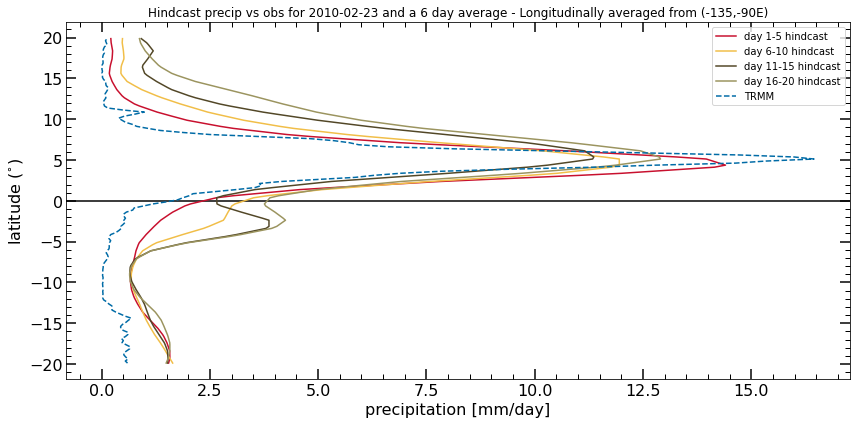

In [6]:
# Plot a comparison between hindcasts and observation

# Set pixel density of plot
_dpi = 100

# Setup the figure
fig = plt.figure(figsize=(12, 6), tight_layout='true')
plt.minorticks_on()
# ax=fig.add_axes()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0', linewidth = 1.5, zorder=-1)
plt.ylabel('latitude $(^{\circ})$', fontsize=16)
plt.xlabel('precipitation [mm/day]', fontsize=16)
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#8B5B29', '#BE531C'] # Go Cyclones! :)
plotLegend = ['day '+str(ii*5+1)+'->'+str((ii+1)*5)+' hindcast' for ii in range(0,4)]

# Loop through the DayXXHcast list to overlay multiple days of hindcast data
for ii, day in enumerate(range(0,4)):
    
    p1 = plt.plot(plotPRECTMultiDay[day]['PRECT'].mean('lon')*1000*86400, 
                  plotPRECTMultiDay[day]['lat'], color = plotColors[ii], 
                  label = 'day '+str(day*5+1)+'-'+str((day+1)*5)+' hindcast') # linewidth = 2.5,    

p2 = plt.plot(plotPRECTObs['pr'].mean('lon'), plotPRECTObs['lat'],  
              color='#006BA6', linestyle='dashed', label='TRMM')
plt.title("Hindcast precip vs obs for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+
          " day average - Longitudinally averaged from ("+str(lonw)+','+str(lone)+'E)')
plt.legend()

# # # Save figure code
# # # Check if folder is there. If it is not, make the folder
# # dir = '/home/jlarson1/'+str(dayOfTheSeason)+' Analysis'
# # if os.path.isdir(dir) == False:
# #     os.mkdir(dir)

# # plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvg'+varName+'LinePlot', bbox_inches='tight', dpi=_dpi)
    
plt.show()

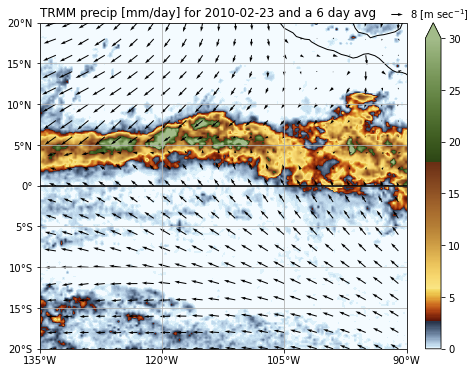

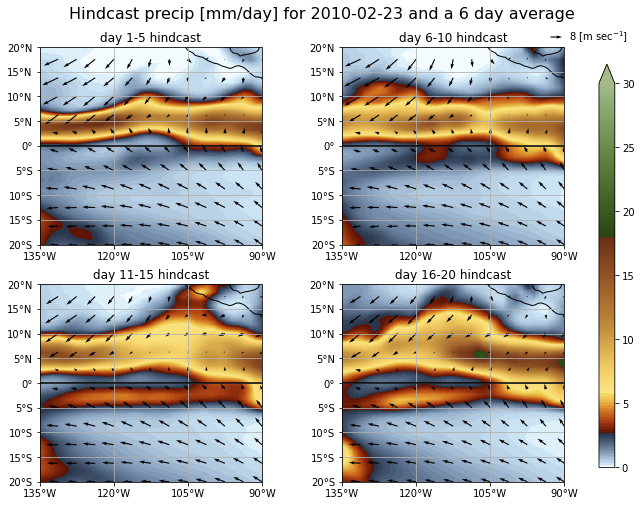

In [7]:
# Create a map plot of the observation data

##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 30
Vmin = 0

# Set density of arrows with n. A greater integer reduces the density of arrows
n = 8

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 200

###########################################

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

# Prepare colormap
mycmap = cm.make_cmap('LarsonColormap.xml')

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
# Use user specified lat values for tick marks
geo_axes.set_yticks(np.arange(lats, latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats, latn+1,5))
plt.axhline(0, color='0', linewidth = 1.5)
image_extent = [lonw,lone,lats,latn]

# Plot precip contour plot
IM = geo_axes.imshow(plotPRECTObs['pr'], extent=image_extent, cmap=plt.get_cmap(mycmap), origin='lower', vmax=Vmax,
                    vmin=Vmin, interpolation='bilinear') 

# Plot wind vectors
quiv = geo_axes.quiver(plotUBOTObs['longitude'][::n], plotUBOTObs['latitude'][::n], plotUBOTObs['u10'][::n,::n], 
                plotVBOTObs['v10'][::n,::n], transform=ccrs.PlateCarree(), scale_units='inches', scale=50)
qk = geo_axes.quiverkey(quiv, 0.99, 1.025, 8, r'8 [m sec$^{-1}$]', labelpos='E')

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, extend='max')
plt.title("TRMM precip [mm/day] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day avg", loc='left')
    
plt.show()

###########################################################################################

# Plot four subplots for each hindcast day

##### Control plotting variables here #####

# Set density of arrows with n. A greater integer reduces the density of arrows
n = 15

###########################################################################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Prepare colormap
# mycmap = cm.make_cmap('LarsonColormap.xml')


# Iterate through the subplots
for ii in range(0,4):
    
    # Plot precip in mm/day
    im = axes.flat[ii].imshow(plotPRECTMultiDay[ii]['PRECT']*1000*86400, 
                              extent=image_extent, origin='lower', cmap=mycmap, vmax=Vmax, vmin=Vmin)
    
    # Plot horizontal wind vectors. The density of these vectors is controlled by n
    quiv = axes.flat[ii].quiver(plotVBOTMultiDay[ii]['lon'][::n], plotVBOTMultiDay[ii]['lat'][::n], 
                                plotUBOTMultiDay[ii]['U'][::n,::n], plotVBOTMultiDay[ii]['V'][::n,::n], 
                                transform=ccrs.PlateCarree(), scale_units='inches', scale=50)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    

qk = axes.flat[ii].quiverkey(quiv, 0.99, 2.25, 8, r'8 [m sec$^{-1}$]', labelpos='E')
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='max')

# Set title for the entire figure
fig.suptitle("Hindcast precip [mm/day] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()

In [8]:
# Calculate the meridional wind error for each group of hindcast days
errVBOT = [plotVBOTMultiDay[ii]['V'].values - plotVBOTObs['v10'].values for ii in range(0,4)]

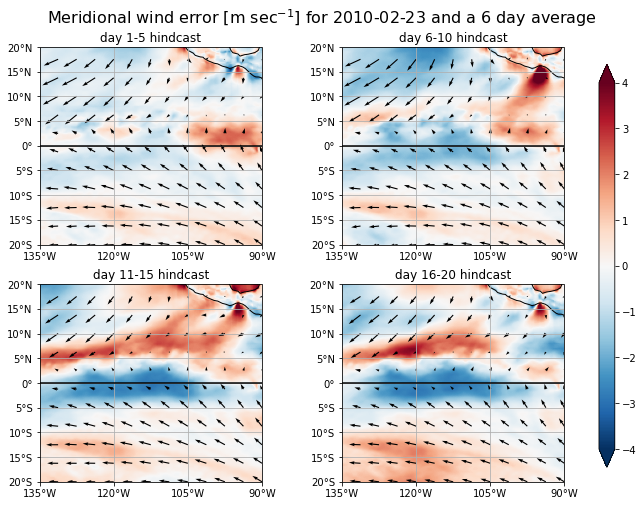

In [9]:
###########################################################################################

# Plot four subplots for each hindcast day

##### Control plotting variables here #####

# Set density of arrows with n. A greater integer reduces the density of arrows
n = 15

# Set the max and min values of the colorbar
Vmax = 4
Vmin = -4

###########################################################################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Prepare colormap
# mycmap = cm.make_cmap('LarsonColormap.xml')


# Iterate through the subplots
for ii, day in enumerate(range(0,4)):
    
    # Plot precip in mm/day
    im = axes.flat[ii].imshow(errVBOT[day], 
                              extent=image_extent, origin='lower', cmap='RdBu_r', vmax=Vmax, vmin=Vmin)
    
    # Plot horizontal wind vectors. The density of these vectors is controlled by n
    quiv = axes.flat[ii].quiver(plotVBOTMultiDay[day]['lon'][::n], plotVBOTMultiDay[day]['lat'][::n], 
                                plotUBOTMultiDay[day]['U'][::n,::n], plotVBOTMultiDay[day]['V'][::n,::n], 
                                transform=ccrs.PlateCarree(), scale_units='inches', scale=50)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(day*5+1)+'-'+str((day+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Meridional wind error [m sec$^{-1}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()